In [2]:
# importar as bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importando o algoritmo K-Means:
from sklearn.cluster import KMeans

# Métrica de avaliação para modelos de clustering:
from sklearn.metrics import silhouette_score

# O pacote warnings inibe a visualização de avisos nos outputs do Colab.
import warnings
warnings.filterwarnings('ignore')

# importando a fórmula que transforma object em tipo número e para normalização dos dados
from sklearn.preprocessing import LabelEncoder, StandardScaler

# importando o PCA para reduzir os números de atributos
from sklearn.decomposition import PCA


#

In [3]:
# carregando dataframe
df = pd.read_csv('/content/household_power_consumption.csv', sep=';')

#transformando os dados em tipo numérico
for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = LabelEncoder().fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1048575 non-null  int64  
 1   Time                   1048575 non-null  int64  
 2   Global_active_power    1048575 non-null  int64  
 3   Global_reactive_power  1048575 non-null  int64  
 4   Voltage                1048575 non-null  int64  
 5   Global_intensity       1048575 non-null  int64  
 6   Sub_metering_1         1048575 non-null  int64  
 7   Sub_metering_2         1048575 non-null  int64  
 8   Sub_metering_3         1044506 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 72.0 MB


In [4]:
# retirando dados NaN e selecionando 5% de amostra aleatória
df = df.dropna().sample(52430)

# Normalizando as colunas numéricas
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['float', 'int']).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52430 entries, 901377 to 329785
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   52430 non-null  float64
 1   Time                   52430 non-null  float64
 2   Global_active_power    52430 non-null  float64
 3   Global_reactive_power  52430 non-null  float64
 4   Voltage                52430 non-null  float64
 5   Global_intensity       52430 non-null  float64
 6   Sub_metering_1         52430 non-null  float64
 7   Sub_metering_2         52430 non-null  float64
 8   Sub_metering_3         52430 non-null  float64
dtypes: float64(9)
memory usage: 4.0 MB


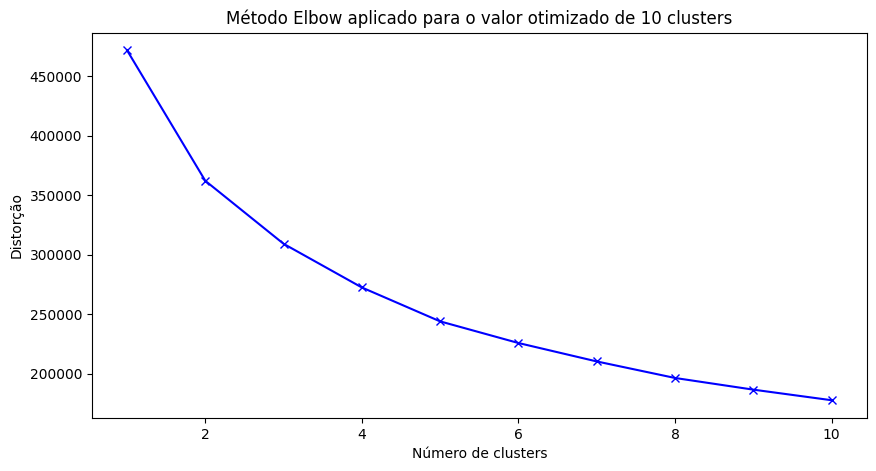

In [5]:

inertia = []
for i in range(1, 11):
  pca = KMeans(n_clusters=i, random_state=42)
  pca.fit(df)
  inertia.append(pca.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, '-bx')

# Define os labels do eixos do gráfico:
plt.xlabel('Número de clusters')
plt.ylabel('Distorção')

# Define um título para o gráfico:
plt.title('Método Elbow aplicado para o valor otimizado de 10 clusters')

# Mostra o gráfico:
plt.show()


In [6]:
# reduzindo os dados com PCA
pca = PCA(n_components=5)
df_reduced = pca.fit_transform(df)
df_reduced.shape

# Verificando o quanto os novos dados explica dos dados originais
explained_variance = pca.explained_variance_ratio_.sum()
print(f"A variância dos novos dados explica {explained_variance * 100:.2f}% dos dados originais.")

A variância dos novos dados explica 76.27% dos dados originais.


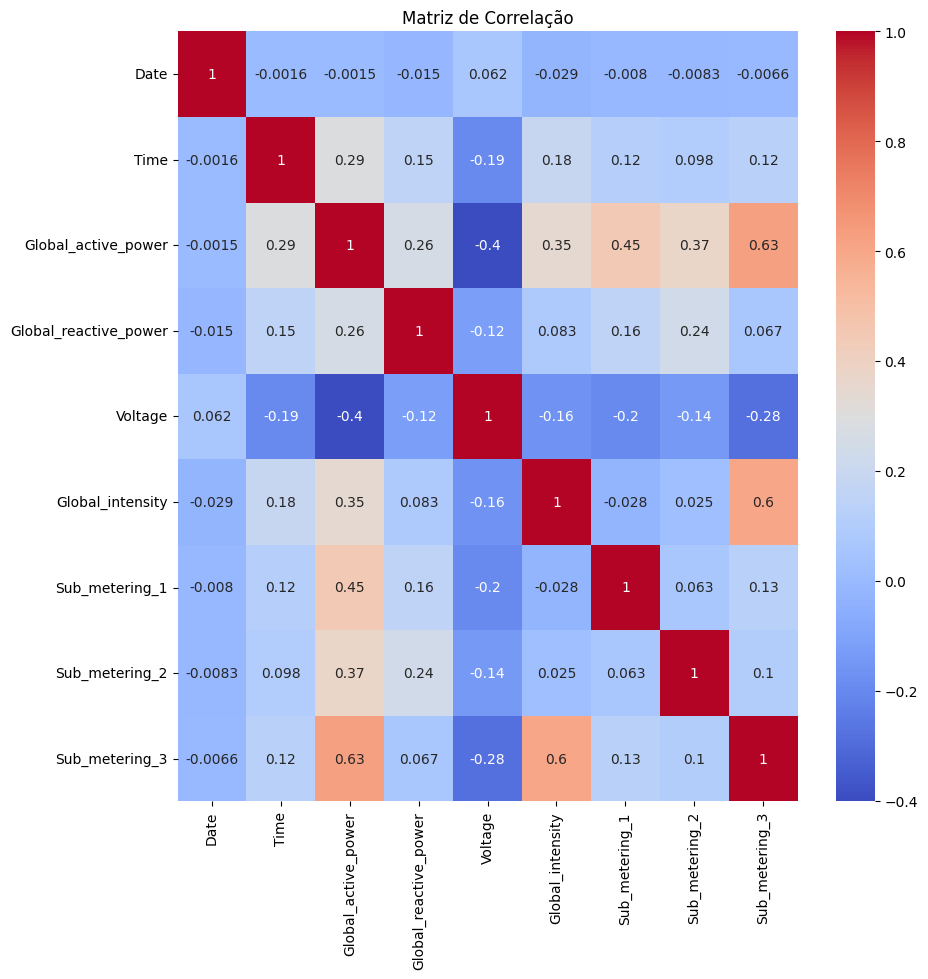

<class 'pandas.core.frame.DataFrame'>
Index: 52430 entries, 901377 to 329785
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    52430 non-null  float64
 1   Global_reactive_power  52430 non-null  float64
 2   Voltage                52430 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB


In [8]:
# escolhendo os atributos necessários para técnica de agrupamento

# Calcula a matriz de correlação
corr = df.corr()

# Plota a matriz de correlação como um heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

df_cor = df[["Global_active_power", "Global_reactive_power", "Voltage"]]
df_cor.info()


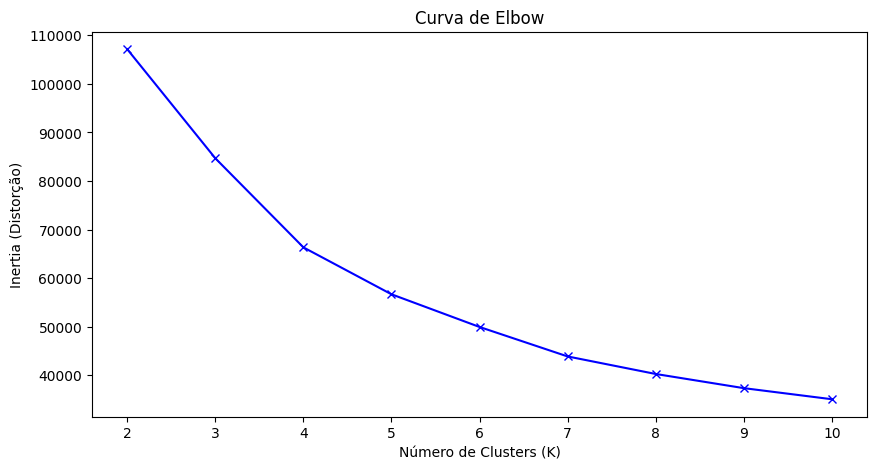

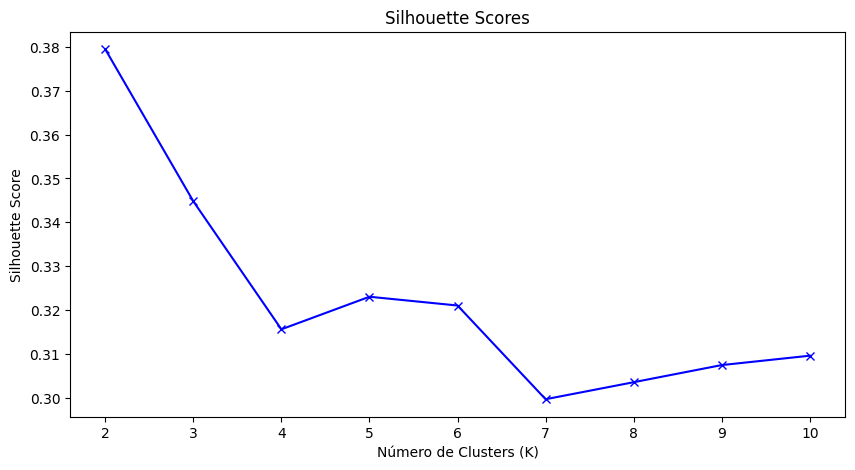

In [10]:
# Lista para armazenar as inertias (distorções)
inertias = []

# Lista para armazenar os silhouette scores
silhouette_scores = []

# Range de valores de K para testar
k_values = range(2, 11)

# Loop para testar diferentes valores de K
for k in k_values:
  # Cria o modelo K-Means com o valor atual de K
  kmeans = KMeans(n_clusters=k, random_state=42)

  # Aplica o modelo aos dados
  kmeans.fit(df_cor)

  # Armazena a inertia (distorção)
  inertias.append(kmeans.inertia_)

  # Calcula e armazena o silhouette score
  if k > 1:
    silhouette_scores.append(silhouette_score(df_cor, kmeans.labels_))

# Plota a curva de Elbow
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertias, '-bx')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inertia (Distorção)')
plt.title('Curva de Elbow')
plt.show()

# Plota os silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, '-bx') # Use k_values instead of k_values[1:] to match dimensions with silhouette_scores.
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.show()
